# Setup

In [103]:
import nltk
from nltk.corpus import reuters

import numpy as np
import random
import re
import time

import torch
import torch.nn as nn
import torch.optim as optim

from scipy.stats import spearmanr
from collections import Counter

In [104]:
# Detect the device for computation (CPU/GPU/Metal on Mac 💻)
device = torch.device(
    "mps" if torch.backends.mps.is_available() else ("cuda" if torch.cuda.is_available() else "cpu")
)
print(f"Using device: {device}")

Using device: cuda


In [105]:
# Ensure required datasets are downloaded
nltk.download("reuters")
nltk.download("punkt")

[nltk_data] Downloading package reuters to /home/jupyter-
[nltk_data]     st125127/nltk_data...
[nltk_data]   Package reuters is already up-to-date!
[nltk_data] Downloading package punkt to /home/jupyter-
[nltk_data]     st125127/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

# Skip-gram Modeling

In [106]:
sample_size = 500
# sample_size = len(reuters.fileids())

def build_corpus():
    corpus = []

    for id in reuters.fileids()[:sample_size]:
        sentences = reuters.words(id)
        sentences = [sentence.lower() for sentence in sentences if sentence.isalpha()]
        corpus.append(sentences)

    return corpus


corpus = build_corpus()
print(f"Sentences in the corpus: {len(corpus)}")
print(f"Words in the corpus: {sum(len(sentence) for sentence in corpus)}")

Sentences in the corpus: 500
Words in the corpus: 62886


In [107]:
def build_vocab(corpus):
    # Flatten words from all sentences
    flatten_words = [word for sentence in corpus for word in sentence]
    word_counts = Counter(flatten_words)

    # Unique words
    vocab = list(set(flatten_words))
    vocab.append("<UNKNOWN>")

    word2index = {word: index for index, word in enumerate(vocab)}
    word2index["<UNKNOWN>"] = 0
    word2index

    return vocab, len(vocab), word2index, word_counts


all_vocabs, vocab_size, word2index, word_counts = build_vocab(corpus)
print(f"Unique words in the corpus: {vocab_size}")

Unique words in the corpus: 6374


In [108]:
def build_skipgrams(corpus, word2index, window_size=2):
    """
    Generate skip-gram pairs from corpus
    """
    skip_grams = []

    for sentence in corpus:
        for position, center_word in enumerate(sentence):
            center_index = word2index[center_word]
            context_indices = list(
                [
                    i
                    for i in range(
                        max(
                            position - window_size, 0
                        ),  # Context words on the left. If none, then 0
                        min(
                            position + window_size + 1, len(sentence)
                        ),  # Context words on the right, If none, then 0
                    )
                    if i != position  # Exclude itself
                ]
            )
            for index in context_indices:
                context_word = sentence[index]
                context_index = word2index[context_word]
                skip_grams.append(
                    (center_index, context_index)
                )  # A tuple representing a skip-gram pair

    return skip_grams


skip_grams = build_skipgrams(corpus, word2index, window_size=2)
print(f"Skip-gram pairs from corpus: {len(skip_grams)}")

Skip-gram pairs from corpus: 248544


In [109]:
def build_unigram_table(word_counts, power=0.75):
    total_count = sum([count for count in word_counts.values()])
    unigram_table = []
    for word, count in word_counts.items():
        score = (count / total_count) ** power
        unigram_table.extend([word] * int(score * 1e6))
    return unigram_table


unigram_table = build_unigram_table(word_counts)

In [110]:
def to_number_sequence(all_vocabs, word2index):
    """
    Convert a sequence of words into a sequence of numerical indices
    """
    indices = list(
        map(  # Apply lambda function to each word in all_vocabs
            lambda w: word2index[w] if word2index.get(w) is not None else word2index["<UNKNOWN>"],
            all_vocabs,
        )
    )
    return torch.LongTensor(indices).to(device)  # List of indices is converted to PyTorch tensor

In [111]:
class Skipgram(nn.Module):  # nn.Module is the base class for all neural network modules in PyTorch

    def __init__(self, vocab_size, embed_size, mode="softmax"):
        super(Skipgram, self).__init__()
        self.mode = mode
        self.embedding_v = nn.Embedding(vocab_size, embed_size)
        self.embedding_u = nn.Embedding(vocab_size, embed_size)

    def forward(self, center_words, target_words, all_vocabs, negative_vocabs=None):
        # Create embedding vectors for center words, target words, and all words
        center_embeds = self.embedding_v(center_words)
        target_embeds = self.embedding_u(target_words)
        all_embeds = self.embedding_u(all_vocabs)

        if self.mode == "softmax":
            # Dot product between the embeddings of the center word and the context word is computed.
            # This measures how similar the center word is to the context word.
            scores = target_embeds.bmm(center_embeds.transpose(1, 2)).squeeze(2)

            # Dot product between the embeddings of the center word and all words in the vocabulary is computed.
            # This is used to normalize the scores across the entire vocabulary (denominator in the softmax function).
            norm_scores = all_embeds.bmm(center_embeds.transpose(1, 2)).squeeze(2)

            # Negative log of the softmax probability is taken. This is the loss for a single prediction.
            # The overall loss is the average of these values across all predictions in the batch.
            negative_log_likelihood = (-1) * (
                torch.mean(
                    torch.log(torch.exp(scores) / torch.sum(torch.exp(norm_scores), 1).unsqueeze(1))
                )
            )
        elif self.mode == "negative_sampling":
            negative_log_likelihood = 0

        return negative_log_likelihood

    def get_embedding(self, word_index):
        return self.embedding_v(torch.tensor([word_index], dtype=torch.long).to(device)).detach().cpu().numpy()
        # return self.embedding_v(torch.LongTensor([word_index]).to(device)).detach().cpu().numpy()

In [112]:
# Hyperparameters
batch_size = 128
embed_size = 100
epochs = 10

def train_skipgrams(mode, skip_grams, all_vocabs, vocab_size):
    if mode not in ["softmax", "negative_sampling"]:
        raise ValueError("Invalid mode.")


    # Model and Optimizer
    model = Skipgram(vocab_size=vocab_size, embed_size=embed_size, mode=mode).to(device)
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    # Convert all_vocabs (list -> tensor) and expands it to match the batch size
    all_vocabs = to_number_sequence(all_vocabs, word2index).expand(batch_size, vocab_size)

    all_losses = []

    # Training loop
    for epoch in range(epochs):
        epoch_loss = []  # Loss for each epoch
        start_time = time.time()

        # Shuffle the skip_grams every epoch
        random.shuffle(skip_grams)

        for i in range(0, len(skip_grams), batch_size):
            current_batch = skip_grams[i : i + batch_size]

            if len(current_batch) == 0:
                continue

            # Unpack current_batch by splitting into two variables
            # center_words = all first elements from each pair
            # target_words = all second elements from each pair
            center_words, target_words = zip(*current_batch)

            # Convert from tuples to 2D numpy arrays
            center_words = np.array(center_words).reshape(-1, 1)
            target_words = np.array(target_words).reshape(-1, 1)

            # Convert from 2D numpy arrays to tensors
            center_words = torch.LongTensor(center_words).to(device)
            target_words = torch.LongTensor(target_words).to(device)

            # RuntimeError: Expected size for first two dimensions of batch2 tensor to be: [128, 200] but got: [124, 200]
            # Pad the batch if it's smaller than batch_size
            if center_words.size(0) < batch_size:
                padding_size = batch_size - center_words.size(0)
                center_words = torch.cat(
                    [center_words, torch.zeros(padding_size, 1, dtype=torch.long).to(device)], dim=0
                ).to(device)
                target_words = torch.cat(
                    [target_words, torch.zeros(padding_size, 1, dtype=torch.long).to(device)], dim=0
                ).to(device)

            # Reset the gradients
            optimizer.zero_grad()

            if mode == "softmax":
                # Computes the loss using model's forward method
                loss = model(center_words, target_words, all_vocabs)
                # Backpropagate the loss
                loss.backward()
                # Updates model parameters
                optimizer.step()

            # print(
            #     f"Epoch {epoch+1} | Batch {i+1}/{(len(skip_grams)+1)} | Center {center_words.size()} | Target {target_words.size()} | Loss {loss.item()}"
            # )

            epoch_loss.append(loss.item())

            elapsed_time = time.time() - start_time

        print(f"Epoch: {epoch+1:3d} | Loss: {np.mean(epoch_loss):5.5f} | Time: {elapsed_time:5.5f}")
        all_losses.append(np.mean(epoch_loss))

    return model, np.mean(all_losses)

In [113]:
model_sm, avg_loss_sm = train_skipgrams(
    mode="softmax", skip_grams=skip_grams, all_vocabs=all_vocabs, vocab_size=len(all_vocabs)
)

Epoch:   1 | Loss: 24.69578 | Time: 10.72375
Epoch:   2 | Loss: 16.49966 | Time: 10.70907
Epoch:   3 | Loss: 12.73225 | Time: 10.72324
Epoch:   4 | Loss: 10.45405 | Time: 10.74137
Epoch:   5 | Loss: 8.99602 | Time: 10.73467
Epoch:   6 | Loss: 8.01177 | Time: 10.79338
Epoch:   7 | Loss: 7.31773 | Time: 10.86632
Epoch:   8 | Loss: 6.81233 | Time: 10.85547
Epoch:   9 | Loss: 6.43423 | Time: 10.73835
Epoch:  10 | Loss: 6.14582 | Time: 10.73482


In [114]:
model_skipgram_sm_path = f"model_skipgram_sm_b{batch_size}_em{embed_size}_ep{epochs}.pth"
torch.save(model_sm.state_dict(), model_skipgram_sm_path)
print("Model saved")

Model saved


In [115]:
model_path = f"model_skipgram_sm_b{batch_size}_em{embed_size}_ep{epochs}.pth"
loaded_model_sm = Skipgram(vocab_size=len(all_vocabs), embed_size=100, mode="softmax").to(device)
loaded_model_sm.load_state_dict(torch.load(model_path, weights_only=True))
print("Model loaded")

Model loaded


# Skip-gram Plotting


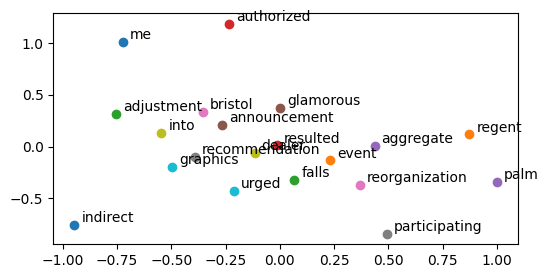

In [116]:
def get_embed(model, word):
    id_tensor = torch.LongTensor([word2index[word]]).to(device)
    v_embed = model_sm.embedding_v(id_tensor)
    u_embed = model_sm.embedding_u(id_tensor)
    word_embed = (v_embed + u_embed) / 2
    x, y = word_embed[0][0].item(), word_embed[0][1].item()

    return x, y


import matplotlib.pyplot as plt

plt.figure(figsize=(6, 3))
for i, word in enumerate(all_vocabs[:20]):  # loop each unique vocab
    x, y = get_embed(loaded_model, word)
    plt.scatter(x, y)
    plt.annotate(word, xy=(x, y), xytext=(5, 2), textcoords="offset points")
plt.show()

# Skip-gram Analogies

In [124]:
def evaluate_analogies(model, analogy_file, word2index):
    semantic_correct = 0
    semantic_total = 0
    syntactic_correct = 0
    syntactic_total = 0

    index2word = {val: key for key, val in word2index.items()}

    section = None

    with open(analogy_file, "r") as f:
        # Lines starting with ":" indicate a new section
        for line in f:
            if line.startswith(":"):
                section = line.strip()[1:].lower()
                continue

            words_in_line = line.strip().lower().split()  # Split each line into words
            if all(
                word in word2index for word in words_in_line
            ):  # All words must be present in word2index
                first_word, second_word, third_word, expected_word = words_in_line
                first_word_emb = model.get_embedding(word2index[first_word])
                second_word_vec = model.get_embedding(word2index[second_word])
                third_word_vec = model.get_embedding(word2index[third_word])

                # Finds the word in the vocabulary whose embedding is closest to the predicted vector
                predicted_idx = np.argmax(
                    np.dot(
                        model.embedding_v.weight.detach().cpu().numpy(),
                        (second_word_vec - first_word_emb + third_word_vec).T,
                    )
                )

                # Retrieve word using predicted index
                predicted_word = index2word[predicted_idx]

                if section == "capital-common-countries":
                    semantic_total += 1
                    if predicted_word == expected_word:
                        semantic_correct += 1

                elif section == "past-tense":
                    syntactic_total += 1
                    if predicted_word == expected_word:
                        syntactic_correct += 1

    # Accuracy ratio
    semantic_accuracy = semantic_correct / semantic_total if semantic_total > 0 else 0
    syntactic_accuracy = syntactic_correct / syntactic_total if syntactic_total > 0 else 0

    print(f"Semantic Accuracy: {semantic_accuracy:.4f}")
    print(f"Syntactic Accuracy: {syntactic_accuracy:.4f}")

    return semantic_accuracy, syntactic_accuracy

In [125]:
analogy_file = "word-test.v1.txt"

evaluate_analogies(loaded_model, analogy_file, word2index)

Semantic Accuracy: 0.0000
Syntactic Accuracy: 0.0000


(0, 0)

# Skip-gram Similarities

In [119]:
def evaluate_similarities(model, similarity_file, word2index):
    """Evaluate similarity correlation using Spearman correlation."""
    human_scores = []
    model_scores = []

    with open(similarity_file, "r") as f:
        for line in f:
            word1, word2, human_score = line.strip().split()
            if word1 in word2index and word2 in word2index:
                word1_vec = model.get_embedding(word2index[word1]).squeeze()
                word2_vec = model.get_embedding(word2index[word2]).squeeze()

                model_score = np.dot(word1_vec, word2_vec)
                human_scores.append(float(human_score))
                model_scores.append(model_score)

    correlation, _ = spearmanr(human_scores, model_scores)
    print(f"Spearman Correlation: {correlation:.4f}")

    mse = np.mean((np.array(human_scores) - np.array(model_scores)) ** 2)

    return human_scores, model_scores, correlation, mse

In [121]:
similarity_file = "wordsim_similarity_goldstandard.txt"

evaluate_similarities(loaded_model, similarity_file, word2index)

Spearman Correlation: -0.0482


([6.81,
  9.15,
  8.46,
  8.94,
  7.52,
  8.42,
  9.04,
  5.85,
  7.59,
  7.56,
  7.88,
  5.0,
  8.97,
  6.44,
  6.88,
  7.63,
  7.63,
  7.78,
  7.13,
  7.89,
  5.25,
  5.56,
  7.83,
  4.97,
  4.94,
  4.75,
  4.62,
  4.59,
  4.5,
  4.47,
  4.47,
  4.47,
  4.38,
  4.25,
  4.13,
  4.06,
  4.06,
  3.97,
  3.88,
  3.88,
  3.85,
  3.73,
  3.63,
  3.56,
  3.38,
  3.38,
  3.31,
  3.31,
  3.25,
  3.16,
  2.88,
  2.75,
  2.69,
  2.25,
  1.81,
  1.81,
  1.77,
  1.75,
  1.62,
  0.92,
  0.88],
 [np.float32(6.0188646),
  np.float32(-3.305159),
  np.float32(12.268101),
  np.float32(11.493192),
  np.float32(-10.971937),
  np.float32(3.488648),
  np.float32(2.1835344),
  np.float32(3.1072528),
  np.float32(0.95440775),
  np.float32(-0.1466861),
  np.float32(-0.34175628),
  np.float32(1.9053909),
  np.float32(-1.70675),
  np.float32(2.289698),
  np.float32(3.1254451),
  np.float32(2.0590937),
  np.float32(9.8953495),
  np.float32(2.3309286),
  np.float32(2.6030207),
  np.float32(-9.201948),
  np.float3